# <center>二 LangGraph中State状态模式

前面我们通过比较`LangChain`中构建`AI Agent`的底层设计解释了`LangGraph`在应对复杂`AI Agent`开发场景中的明显优势。在`LangGraph`框架中，**不论构建的代理简单或复杂，其本质都是通过节点（Node）和边（Edge）的有机组合来形成一个完整的图（Graph）**。这种构建方式所形成的工作流逻辑十分清晰：每个节点在完成其任务后，都会通过边来指示下一个工作步骤，从而赋予整个应用系统更高的灵活性和可扩展性。掌握三个核心组件——状态（State）、节点（Node）和边（Edge），并了解如何使用这些基本元素构建完整的图形结构是学习和应用`LangGraph`框架重要且最基础的一步。通过深入理解这些关键组件足够支撑我们去设计并实现更加复杂且功能丰富的基于`LangGraph`的`AI Agent`应用程序。

&emsp;&emsp;**在`AI Agent`应用程序的设计中，场景的复杂性直接决定了构建图的复杂度。**例如，最简单的场景可能仅涉及一个大模型的问答流程，形式为：START -> Node -> END（其中大模型的交互逻辑被封装在Node中）。而更复杂的场景则可能涉及多个`AI Agent`的协同工作，包括多个分支和循环的构成。无论是简单还是复杂的图，`LangGraph`的价值永远不在于如何去定义节点，如何去定义边，而是在于**如何有效管理各个节点的输入和输出，以保持图的持续运行状态**。`LangGraph`的**底层图算法采用消息传递机制来定义和执行这些图中的交互流程，其中状态（State）组件扮演着关键的载体角色，负责在图的各个节点之间传递信息**。这也就意味着，`LangGraph`框架的核心在于`State`的有效使用和掌握。在复杂的应用中，`State`组件需要存储和管理的信息量会显著增加。核心功能如工具使用、记忆能力和人机交互等，都依赖`State`来实现和维护**。所以，接下来我们对`LangGragh`框架的探索，都将紧密围绕`State`的实现和应用机制展开，这包括`LangGraph`内置封装好的工具/方法的使用，以及我们自定义构建功能时的实现方法。

&emsp;&emsp;因此，**对于`LangGraph`的底层图算法是利用消息传递机制来定义程序的运行**这一结论，接下来，我们将详细探讨消息（Messages）是如何通过`State`进行传递的，其中包含了什么传递模式和内容。

## 1. LangGraph中State的定义模式

&emsp;&emsp;为了更清晰地说明这一过程，我们可以借助如下流程图来理解消息在图结构中的流转过程：👇

<div align=center><img src="../pic/lesson02/1.png" width=100%></div>

&emsp;&emsp;`LangGraph`构建的图中的每个节点都具备访问、读取和写入状态的权限。当某一个节点去修改状态时，它会将此信息广播到图中的所有其他节点。这种广播机制允许其他节点响应状态的变化并相应地调整其行为。如上图所示，从初始状态（Initial State）开始，其中包含了一条消息 { "x": "10" }，随着消息在节点间通过边传递，每个节点根据其逻辑对状态进行更新。Node 1 和 Node 2 分别对状态进行了处理和变更，结果是在图的末端，我们得到了一个包含三条消息的最终状态 { "x": "10" }, { "x": "11" }, { "y": "9" }。**从开发的角度来看，`State`实际上是一个共享的数据结构。如上图所示，状态表现为一个简单的字典。通过对这个字典进行读写操作，可以实现自左而右的数据流动，从而构建一个可运行的图结构。那么根据前面学习的内容，我们可以利用这个流程来复现并理解图中的动态数据交换，整体的设计如下：

<div align=center><img src="../pic/lesson02/2.png" width=100%></div>

### 1.1 使用字典类型定义状态

&emsp;&emsp;对于上图中的数据场景，我们来实际的进行代码复现。

&emsp;&emsp;首先，我们将图的状态设计为一个字典，用于在不同节点间共享和修改数据，然后使用`StateGraph`类进行图的实例化。代码如下：

In [30]:
from langgraph.graph import StateGraph

# 构建图
builder = StateGraph(dict) 

In [31]:
builder.schema

dict

&emsp;&emsp;接下来，定义两个节点。`addition`节点是一个加法逻辑，接收当前状态，将字典中`x`的值增加1，并返回新的状态。而`subtraction`节点是一个减法逻辑，接收从`addition`节点传来的状态，从字典中的`x`值减去2，创建并返回一个新的键y。

In [32]:
def addition(state):
    print(state)
    return {"x": state["x"] + 1}

def subtraction(state):
    print(state)
    return {"y": state["x"] - 2}

&emsp;&emsp;然后，进行图结构的设计。具体来看，我们添加名为`addition`和`subtraction`的节点，并关联到上面定义的函数。设定图的起始节点为`addition`，并从`addition`到`subtraction`设置一条边，最后从`subtraction`到结束节点设置另一条边。代码如下：

In [33]:
from langgraph.graph import START, END


# 向图中添加两个节点
builder.add_node("addition", addition)
builder.add_node("subtraction", subtraction)

# 构建节点之间的边
builder.add_edge(START, "addition")
builder.add_edge("addition", "subtraction")
builder.add_edge("subtraction", END)

In [34]:
builder.edges

{('__start__', 'addition'),
 ('addition', 'subtraction'),
 ('subtraction', '__end__')}

In [35]:
builder.nodes

{'addition': StateNodeSpec(runnable=addition(tags=None, recurse=True, func_accepts_config=False, func_accepts={'writer': False, 'store': False}), metadata=None, input=<class 'dict'>, retry_policy=None, ends=()),
 'subtraction': StateNodeSpec(runnable=subtraction(tags=None, recurse=True, func_accepts_config=False, func_accepts={'writer': False, 'store': False}), metadata=None, input=<class 'dict'>, retry_policy=None, ends=())}

In [36]:
builder.schema

dict

&emsp;&emsp;最后，执行图的编译。需要通过调用`compile()`方法将这些设置编译成一个可执行的图。代码如下所示：

In [37]:
graph = builder.compile()

&emsp;&emsp;除了上述通过打印的方式查看构建图的结构，`LangGraph`还提供了多种内置的图形可视化方法，能够将任何`Graph`以图形的形式展示出来，帮助我们更好地理解节点之间的关系和流程的动态变化。**可视化最大的好处是：直接从代码中生成图形化的表示，可以检查图的执行逻辑是否符合构建的预期。**`LangGraph`提供的三种图形可视化方法如下：

- **Mermaid.Ink**：一个开源服务，可以根据 Mermaid 代码生成图表的 URL。它通过 API 提供多种输出格式，包括 PNG、JPEG、SVG 和 PDF，并可以自定义尺寸、主题和背景颜色等选项。开源仓库👉：[mermaid](https://github.com/mermaid-js/mermaid)
- **Mermaid + Pyppeteer**：使用 Mermaid 结合 Pyppeteer 的主要区别在于如何将 Mermaid 图表转换成图像或其他格式。Mermaid 本身是一个轻量级的工具，用于通过文本描述生成图表的图形表示。而 Pyppeteer 是一个 Python 库，它提供了一个接口来控制 Chrome，自动打开包含 Mermaid 图表的网页，然后通过浏览器自动截图功能捕获这些图表，生成图像文件。
- **Graphviz**：Graphviz 是一个图形可视化软件，主要用于自动图形布局。它非常适合于复杂图形的生成，如有向图和无向图，而且它支持多种格式的图像输出，如 PNG、SVG、PDF 等，有更精细的布局控制。

> https://langchain-ai.github.io/langgraph/how-tos/visualization/

<div align=center><img src="../pic/lesson02/3.png" width=90%></div>

&emsp;&emsp;如果是`Linux`操作系统，建议使用`Graphviz`工具。而`Windows`系统建议使用`Mermaid + Pyppeteer`方法，因为在`Windwos`中`Graphviz`并不能直接通过 `pip install`的形式安装，编译安装的方法较为复杂。这里我们就使用`Mermaid + Pyppeteer`来进行图的可视化操作。首先，在当前的虚拟环境中安装依赖包，执行如下代码：

In [27]:
 ! pip install pyppeteer ipython

Looking in indexes: http://mirrors.aliyun.com/pypi/simple


&emsp;&emsp;生成图结构的可视化非常直接，只需一行代码即可完成。具体代码如下：


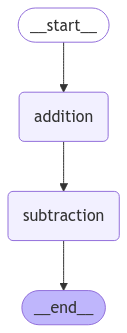

In [28]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

&emsp;&emsp;当通过 `builder.compile()` 方法编译图后，编译后的 `graph` 对象提供了 `invoke` 方法，该方法用于启动图的执行。我们可以通过 `invoke` 方法传递一个初始状态（如 `initial_state = {"x": 10}`），这个状态将作为图执行的起始输入。代码如下：

In [29]:
# 定义一个初始化的状态
initial_state = {"x":10}

graph.invoke(initial_state)

{'x': 10}
{'x': 11}


{'y': 9}

&emsp;&emsp;在图的执行过程中，每个节点的函数会被调用，并且接收到前一个节点返回的状态作为输入。每个函数处理完状态后，会输出一个新的状态，传递给下一个节点。这里需要注意的一个关键信息是：节点函数不需要返回整个状态，而是仅返回它们更新的部分。也就是说：在每个节点的函数内部逻辑中，需要使用和更新哪些`State`中的参数中，只需要在`return`的时候指定即可，不必担心未在当前节点处理的State中的其他值会丢失，因为LangGraph的内部机制已经自动处理了状态的合并和维护。

&emsp;&emsp;上述代码执行过程中图的运行状态如下图所示：👇

<div align=center><img src="../pic/lesson02/4.png" width=100%></div>

&emsp;&emsp;总体来看，该图设置了一个简单的工作流程。其中值首先在第一个节点通过加法函数增加，然后在第二个节点通过减法函数减少。这一流程展示了节点如何通过图中的共享状态进行交互。需要注意的是，状态在任何给定时间只包含来自一个节点的更新信息。这意味着当节点处理状态时，它只能访问与其特定操作直接相关的数据，从而确保每个节点的逻辑是隔离和集中的。使用字典作为状态模式非常简单，由于缺乏预定义的模式，节点可以在没有严格类型约束的情况下自由地读取和写入状态，这样的灵活性有利于动态数据处理。然而，这也要求开发者在整个图的执行过程中保持对键和值的一致性管理。因为如果在任何节点中尝试访问`State`中不存在的键，会直接中断整个图的运行状态。

&emsp;&emsp;到此为止，我们可以来思考一个问题：既然所有节点都会向状态（State）发出更新，为什么仅通过返回需要更新的键值，就能实现状态的全局共享呢？除此之外，如果我们需要对状态进行更复杂的操作，如新增、删除或修改等，应该如何构造这些操作呢？这就引出了我们需要深入理解的概念——在 `LangGraph` 中如何利用 `Reducer` 函数来精细控制状态的变化。

### 1.2 Reducer函数的机制

&emsp;&emsp;`LangGraph`内部**原理是：`State`中的每个`key`都有自己独立的`Reducer`函数，通过指定的`reducer`函数应用状态值的更新。**

&emsp;&emsp;`Reducer` 函数用来根据当前的状态（state）和一个操作（action）来计算并返回新的状态。它是一种设计模式，用于将业务逻辑与状态变更解耦，使得状态的变更预测性更强并且容易追踪。这样的函数通常接收两个参数：当前的状态（state）和一个描述应用了什么操作的对象（action）， 根据 `action` 类型来决定如何修改状态。比如，在一个购物车应用中，可能会有添加商品、删除商品、修改商品数量等操作。返回一个新的状态对象，而不是修改原始状态对象。**简单理解，`Reducer`函数做的就是根据给定的输入（当前状态和操作）生成新的状态。**

> LangGraph Update State 源码：https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.graph.CompiledGraph.update_state

&emsp;&emsp;`LangGraph`中，如果没有显示的指定，则对该键的所有更新都执行的是覆盖操作。我们看一下下面这段代码：

In [53]:
from typing_extensions import TypedDict
from langgraph.graph import START, StateGraph, END

def addition(state):
    print(state)
    return {"x": state["x"] + 1}

def subtraction(state):
    print(state)
    return {"x": state["x"] - 2}

class State(TypedDict):
    x: int
    y: int


# 构建图
builder = StateGraph(State) 

# 向图中添加两个节点
builder.add_node("addition", addition)
builder.add_node("subtraction", subtraction)

# 构建节点之间的边
builder.add_edge(START, "addition")
builder.add_edge("addition", "subtraction")
builder.add_edge("subtraction", END)

graph = builder.compile()

# 定义一个初始化的状态
initial_state = {"x":10}

graph.invoke(initial_state)

{'x': 10}
{'x': 11}


{'x': 9}

&emsp;&emsp;在这里，我们通过使用 `TypedDict` 来定义 `State` 的模式，从而精确控制图结构中状态信息的格式和类型。与上面所使用的传统字典类型相比，`TypedDict` 允许我们明确指定每个键的类型，有助于防止在状态管理过程中出现类型错误。我们强烈建议在开发过程中采用这种方式来定义和管理状态，特别是在涉及复杂状态逻辑和多个状态依赖的应用中。

&emsp;&emsp;接下来 我们再看另一种情况：在下面的图中，`State`还是一个结构化字典，其中包含一个名为 messages 的键，该键保存一个字符串列表。我们用这个状态管理节点在执行期间将处理的数据。状态的模式是使用`TypedDict`定义，它指定消息是带注释的字符串列表。该注释包括`operator.add`，表示可以通过使用添加操作将新消息与现有消息组合来更新列表。代码如下：

In [54]:
import operator
from typing import Annotated, TypedDict, List

class State(TypedDict):
    messages: Annotated[List[str], operator.add]

> messages：这是字典中的一个键，它表示某个字段（比如消息列表）。
List[str]：这是这个字段值的数据类型，它表示一个字符串类型的列表（即一个包含多个字符串的集合）。
Annotated[List[str], operator.add]：这是一个类型注解的特殊用法，它使用 Annotated 来附加额外的元数据（在这里是 operator.add）。Annotated 是 Python 3.9 引入的，它允许你在指定类型的同时附加额外的信息（例如，方法、操作符等）。
operator.add 是 Python 中的一个加法运算符，通常用来对数字进行加法操作。在这里，它作为元数据附加在 List[str] 类型后面，表明这个字段 messages 可能会涉及到某些与加法相关的操作，虽然这里并没有直接用到它。

&emsp;&emsp;当定义状态模式的结构发生了变化以后，在节点函数中的读取和存储逻辑也要发生相应的变化。流程图如下：

<div align=center><img src="../pic/lesson02/5.png" width=100%></div>

&emsp;&emsp;上图中的完整代码复现如下：

In [55]:
def addition(state):
    print(state)
    msg = state['messages'][-1]
    response = {"x": msg["x"] + 1}
    return {"messages": [response]}

def subtraction(state):
    print(state)
    msg = state['messages'][-1]
    response = {"x": msg["x"] - 2}
    return {"messages": [response]}

In [56]:
# 构建图
builder = StateGraph(State) 

# 向图中添加两个节点
builder.add_node("node1", addition)
builder.add_node("node2", subtraction)

# 构建节点之间的边
builder.add_edge(START, "node1")
builder.add_edge("node1", "node2")
builder.add_edge("node2", END)

graph = builder.compile()

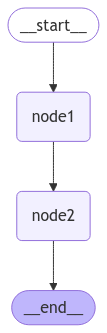

In [57]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [58]:
input_state = {'messages': [{"x": 10}]}

graph.invoke(input_state)

{'messages': [{'x': 10}]}
{'messages': [{'x': 10}, {'x': 11}]}


{'messages': [{'x': 10}, {'x': 11}, {'x': 9}]}

In [17]:
graph.invoke({'messages': [{"x": 32}]})

{'messages': [{'x': 32}]}
{'messages': [{'x': 32}, {'x': 33}]}


{'messages': [{'x': 32}, {'x': 33}, {'x': 31}]}

In [18]:
graph.invoke({'messages': [{"x": 44}]})

{'messages': [{'x': 44}]}
{'messages': [{'x': 44}, {'x': 45}]}


{'messages': [{'x': 44}, {'x': 45}, {'x': 43}]}

&emsp;&emsp;通过这样的例子我们可以理解：`Reducers` 的目的是在`LangGraph`框架中的状态管理系统中，允许更灵活地定义状态如何根据各种操作更新。通过指定不同的 `reducer` 函数，我们可以控制状态的每个部分应如何响应特定的更新。

### 1.3 在图状态中处理消息的思路

&emsp;&emsp;`Reducer`机制的一个现实意义是：我们可以基于这种方式去构建历史对话记录。因为目前大多数大模型应用都是接受消息列表作为输入。 就像`LangChain`中的`Chat Model`，需要接收`Message`对象列表作为输入。这些消息有多种形式，例如HumanMessage （用户输入）或AIMessage （ 大模型响应）。

&emsp;&emsp;下面这个示例，我们进一步将大模型接入到 `LangGraph` 工作流程中，并允许动态消息处理以及与模型的交互。其余组件与先前定义的图中的组件相同。在这里，第一个节点调用大模型并生成一个输出，该输出是一个`AIMessage`对象类型，然后，第二个节点直接将前一个节点的 `AIMessage` 提取为具体的`JSON`格式，完整代码如下：

In [59]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

import getpass
import os

key="sk-kDWtZI5R2tOWLYiREfzzsD7Z3XEsEH5n6SClKqZ4Lxr5GcM"
base_url="https://chatapi.littlewheat.com/v1"

In [60]:
import getpass
import os
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
import operator
from typing import Annotated, TypedDict, List
from langgraph.graph import StateGraph,  END
from IPython.display import Image, display
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage


llm = ChatOpenAI(model="gpt-4o", api_key=key,base_url=base_url,temperature=0,)


# 定义图的状态模式
class State(TypedDict):
    messages: Annotated[List[str], operator.add]

# 创建图的实例
builder = StateGraph(State)

def chat_with_model(state):
    print(state)
    print("-----------------")
    messages = state['messages']
    response = llm.invoke(messages)
    return {"messages": [response]}

def convert_messages(state):
    # "您是一位数据提取专家，负责从文本中检索关键信息。请为所提供的文本提取相关信息，并以 JSON 格式输出。概述所提取的关键数据点。"
    EXTRACTION_PROMPT = """
    You are a data extraction specialist tasked with retrieving key information from a text.
    Extract such information for the provided text and output it in JSON format. Outline the key data points extracted.
    """
    print(state)
    print("-----------------")
    messages = [
        SystemMessage(content=EXTRACTION_PROMPT),
        HumanMessage(content=state['messages'][-1].content)
    ]
    
    response = llm.invoke(messages)
    return {"messages": [response]}

# 添加节点
builder.add_node("chat_with_model", chat_with_model)
builder.add_node("convert_messages", convert_messages)

# 设置启动点
builder.set_entry_point("chat_with_model")

# 添加边
builder.add_edge("chat_with_model", "convert_messages")
builder.add_edge("convert_messages", END)

# 编译图
graph = builder.compile()

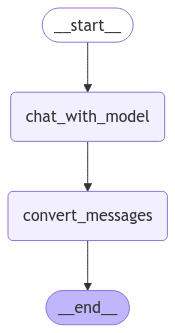

In [61]:
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [62]:
query="你好，请你介绍一下你自己"
input_message = {"messages": [HumanMessage(content=query)]}

result = graph.invoke(input_message)

print(result)

{'messages': [HumanMessage(content='你好，请你介绍一下你自己', additional_kwargs={}, response_metadata={})]}
-----------------
{'messages': [HumanMessage(content='你好，请你介绍一下你自己', additional_kwargs={}, response_metadata={}), AIMessage(content='你好！我是一个由OpenAI开发的人工智能助手，设计目的是帮助回答问题、提供信息和支持各类任务。无论是各种话题的知识，还是具体问题的解答，我都会尽力帮助你。如有需要，请随时问我！', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 58, 'prompt_tokens': 14, 'total_tokens': 72, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': None, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': None}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f3927aa00d', 'finish_reason': 'stop', 'logprobs': None}, id='run-d0dda7a6-cd34-4d03-b6ae-042ac2755cda-0', usage_metadata={'input_tokens': 14, 'output_tokens': 58, 'total_tokens': 72, 'input_token_details': {}, 'output_token_details': {}})]}
--------------

In [63]:
print(result["messages"][-1].content)

```json
{
  "entity": "OpenAI",
  "role": "Artificial Intelligence Assistant",
  "capabilities": [
    "Answering questions",
    "Providing information",
    "Supporting various tasks"
  ],
  "functions": [
    "Knowledge on various topics",
    "Specific problem-solving"
  ],
  "offer": "Help and support as needed"
}
```


&emsp;&emsp;如上所示，在许多现实开发情况下，将先前的对话历史记录存储为图形状态中的消息列表是必须要做的。而实现这一功能，在`LangGraph`框架中可以向存储`Message`对象列表的图状态添加一个键（通道），并使用`Reducer`函数对其进行注释，从而告诉图在每次状态更新时（例如，当节点发送更新时）更新状态中的`Message`对象列表。如上所演示的案例中，简单地将消息追加到现有列表中，就是通过`operator.add`实现。

### 1.4 MessageGraph源码功能解析

&emsp;&emsp;更复杂一点的，如果我们还想手动更新图形状态中的消息（例如人机交互），**使用`operator.add`能做到的功能极限是：发送到图表的手动状态更新将被附加到现有的消息列表中，而不是更新现有的消息。**为了避免这种情况，我们则需要一个可以跟踪消息 ID 并覆盖现有消息（如果更新）的`Reducer`函数。为此，就引出了`LangGraph`预构建的`add_messages`函数，这个更高级的`Reducer`所实现的是：**对于全新的消息，它会附加到现有列表，但它也会正确处理现有消息的更新。如何理解这句话呢？我们接下来就从源码角度进行详细解析。**

&emsp;&emsp;上节课程中我们分析过`LangGraph` 中的 `StateGraph`类，这个类允许我们创建图，其节点通过读取和写入共享状态进行通信。 `StateGraph` 类由开发者定义的 `State` 对象进行参数化，该对象表示图中的节点将通过其进行通信的共享数据结构。

&emsp;&emsp;`MessageGraph` 是 `StateGraph` 的一个子类，使用了 `Annotated[list[AnyMessage], add_messages]` 来初始化其基类 `StateGraph`。这里的 `list[AnyMessage]` 指明了 `MessageGraph` 的状态由消息列表组成，而这个列表类型是一个可以不断添加消息的结构（因为列表是可变的数据类型），`MessageGraph` 中的每个节点都将消息列表作为输入，并返回零个或多个消息作为输出。`add_messages`函数用于将每个节点的输出消息合并进图的状态中已存在的消息列表。其源码定义如下：

> MessageGraph 源码：https://github.com/langchain-ai/langgraph/blob/e3ef9adac7395e5c0943c22bbc8a4a856b103aa3/libs/langgraph/langgraph/graph/message.py#L150

```python
class MessageGraph(StateGraph):
    def __init__(self) -> None:
        super().__init__(Annotated[list[AnyMessage], add_messages]])
```

&emsp;&emsp;`Messages`图可以单独构建，如下代码所示：

In [64]:
import getpass
import os
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate



llm = ChatOpenAI(model="gpt-4o", api_key=key,base_url=base_url,temperature=0,)

def chatbot(state: State):
    print(state)
    return {"messages": [llm.invoke(state["messages"])]}

In [65]:
from langgraph.graph.message import MessageGraph

builder = MessageGraph()

builder.add_node("chatbot", lambda state: [("assistant", "你好，最帅气的人！")])

builder.set_entry_point("chatbot")

builder.set_finish_point("chatbot")

graph = builder.compile()

In [66]:
graph.invoke([("user", "你好，请你介绍一下你自己.")])

[HumanMessage(content='你好，请你介绍一下你自己.', additional_kwargs={}, response_metadata={}, id='9fc9f4cd-6fde-494b-8369-9d284853209a'),
 AIMessage(content='你好，最帅气的人！', additional_kwargs={}, response_metadata={}, id='cf389628-27ea-438f-a766-02b631d8df4d')]

In [67]:
graph.invoke([("user", "Hi 3213.")])

[HumanMessage(content='Hi 3213.', additional_kwargs={}, response_metadata={}, id='a120d524-44da-4864-a93f-8fe104c77231'),
 AIMessage(content='你好，最帅气的人！', additional_kwargs={}, response_metadata={}, id='044da664-0bbb-42a6-b606-e17b75e2f1e4')]

&emsp;&emsp;MessageGraph通过使用单个仅附加消息列表作为其整个状态来管理状态，其中每个节点处理该列表并可以返回其他消息。这种设计特别适合对话式应用程序，可以轻松跟踪对话历史和交互。

&emsp;&emsp;继而进一步来看`add_messages`这个`Reducer`函数的定义情况：

```python

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


def add_messages(left: Messages, right: Messages) -> Messages:
    """Merges two lists of messages, updating existing messages by ID.

    By default, this ensures the state is "append-only", unless the
    new message has the same ID as an existing message.

    Args:
        left: The base list of messages.
        right: The list of messages (or single message) to merge
            into the base list.

    Returns:
        A new list of messages with the messages from `right` merged into `left`.
        If a message in `right` has the same ID as a message in `left`, the
        message from `right` will replace the messagage(content='Hello', id=...)]}
        ```

    """
    # coerce to list
    if not isinstance(left, list):
        left = [left]  # type: ignore[assignment]
    if not isinstance(right, list):
        right = [right]  # type: ignore[assignment]
    # coerce to message
    left = [
        message_chunk_to_message(cast(BaseMessageChunk, m))
        for m in convert_to_messages(left)
    ]
    right = [
        message_chunk_to_message(cast(BaseMessageChunk, m))
        for m in convert_to_messages(right)
    ]
    # assign missing ids
    for m in left:
        if m.id is None:
            m.id = str(uuid.uuid4())
    for m in right:
        if m.id is None:
            m.id = str(uuid.uuid4())
    # merge
    left_idx_by_id = {m.id: i for i, m in enumerate(left)}
    merged = left.copy()
    ids_to_remove = set()
    for m in right:
        if (existing_idx := left_idx_by_id.get(m.id)) is not None:
            if isinstance(m, RemoveMessage):
                ids_to_remove.add(m.id)
            else:
                merged[existing_idx] = m
        else:
            if isinstance(m, RemoveMessage):
                raise ValueError(
                    f"Attempting to delete a message with an ID that doesn't exist ('{m.id}')"
                )

            merged.append(m)
    merged = [m for m in merged if m.id not in ids_to_remove]
    return merged
```

> LangGraph add_messages：https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.message.add_messages

&emsp;&emsp;`add_messages`整体的核心逻辑是合并两个消息列表，按 `ID` 更新现有消息。默认情况下，状态为“仅附加”，当新消息与现有消息具有相同的 ID时，进行更新。具体参数是：
- left （ Messages ） – 消息的基本列表。
- right （ Messages ） – 要合并到基本列表中的消息列表（或单个消息）。

&emsp;&emsp;而返回值是一个消息列表，其中的合并逻辑则是：如果right的消息与left的消息具有相同的 ID，则right的消息将替换left的消息，否则作为一条新的消息进行追加。

In [68]:
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage

msgs1 = [HumanMessage(content="你好。", id="1")]
msgs2 = [AIMessage(content="你好，很高兴认识你。", id="2")]

add_messages(msgs1, msgs2)

[HumanMessage(content='你好。', additional_kwargs={}, response_metadata={}, id='1'),
 AIMessage(content='你好，很高兴认识你。', additional_kwargs={}, response_metadata={}, id='2')]

In [69]:
msgs1 = [HumanMessage(content="你好。", id="1")]
msgs2 = [HumanMessage(content="你好呀。", id="1")]

add_messages(msgs1, msgs2)

[HumanMessage(content='你好呀。', additional_kwargs={}, response_metadata={}, id='1')]

&emsp;&emsp;消息状态管理不仅可以在`MessageGraph`中定义，还可以在`StateGraph`中定义。相比之下， `StateGraph`允许更复杂的状态结构，其中状态可以是任何 Python 类型（如 TypedDict 或 Pydantic 模型），并且可以通过各种方式更新。 `StateGraph` 中的每个节点都会接收当前状态并返回更新后的状态，从而实现除消息处理之外的更复杂的数据操作和工作流程。因此，`MessageGraph` 专门用于以消息为中心的工作流程，而 `StateGraph` 则更通用，适用于更广泛的应用程序。

&emsp;&emsp;所以，对于人机交互的程序，在`LangGraph`的开发流程中，我们一般会首先创建一个`StateGraph` , `StateGraph`对象将应用程序的结构定义为“状态机”，比如下面的这个接入大模型的聊天机器人：

In [70]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

&emsp;&emsp;`State`是一个带有单个键的`TypedDict` ： `messages` 。 `messages`键使用`add_messages`作为`Reducer`函数告诉 `LangGraph` 将新消息追加到现有列表中，而不是覆盖它。

In [71]:
import getpass
import os
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate



llm = ChatOpenAI(model="gpt-4o", api_key=key,base_url=base_url,temperature=0,)

def chatbot(state: State):
    # print(state)
    return {"messages": [llm.invoke(state["messages"])]}

&emsp;&emsp;接下来，添加一个`chatbot`节点，将当前`State`作为输入并返回一个字典，该字典中更新了`messages`中的状态信息。

In [72]:
graph_builder.add_node("chatbot", chatbot)

In [73]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

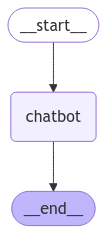

In [74]:
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

&emsp;&emsp;通过一个程序构建可交互式的聊天机器人。完整代码如下：

In [75]:
def stream_graph_updates(user_input: str):  
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("模型回复:", value["messages"][-1].content)


while True:
    try:
        user_input = input("用户提问: ")
        if user_input.lower() in ["退出"]:
            print("下次再见！")
            break

        stream_graph_updates(user_input)
    except:
        break

用户提问:  你好


模型回复: 你好！有什么我可以帮助你的吗？


用户提问:  介绍一下你自己


模型回复: 你好！我是一个由OpenAI开发的人工智能助手，可以帮助你回答各种问题、提供信息、协助解决问题等。无论是学术问题、日常生活小常识，还是技术支持，我都会尽力为你提供准确而有用的帮助。如果你有任何问题或需要信息，随时问我！


用户提问:  什么是LangGraph


模型回复: 到目前为止，我没有关于“LangGraph”的具体信息。它可能是一个新发布的工具、项目或概念。对于这种不太知名的术语，建议你查阅相关的文档、官方网站或在线资源，以获取最新的信息。如果你有更多关于它的上下文或描述，我可以尝试帮助你理解或分析。


用户提问:  退出


下次再见！


&emsp;&emsp;掌握`State`的定义模式和消息传递是`LangGraph`中最关键，也是构建应用最核心的部分，所有的高阶功能，如工具调用、上下文记忆，人机交互等依赖`State`的管理和使用，所以大家务必理解并掌握上述相关内容。这一部分我们在下一节课中展开详细的介绍，接下来我们先给大家介绍一个实用的开发工具：LangSmith。